In [18]:
import os
import pydicom
import numpy as np
import glob
import scipy.ndimage
import matplotlib.pyplot as plt
import SimpleITK as sltk

from pydicom.filereader import read_dicomdir
from skimage import measure, morphology, transform
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

%matplotlib inline

datadir_path = "./data/05dzgcM/"

In [26]:
files = []
slices = []

def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)


for fname in glob.glob(datadir_path + '*.dcm', recursive=True):
    files.append(pydicom.read_file(fname))

# skip files with no SliceLocation (eg scout views)
skipcount = 0
for f in files:
    if hasattr(f, 'SliceLocation'):
        slices.append(f)
    else:
        skipcount = skipcount + 1
print("skipped (no SliceLocation): {}".format(skipcount))

# ensure they are in the correct order
slices = sorted(slices, key=lambda s: s.SliceLocation)

# # pixel aspects, assuming all slices are the same
# ps = slices[0].PixelSpacing
# ss = slices[0].SliceThickness
# ax_aspect = ps[1]/ps[0]
# sag_aspect = ps[1]/ss
# cor_aspect = ss/ps[0]

# # create 3D array
# img_shape = list(slices[0].pixel_array.shape)
# img_shape.append(len(slices))
# img3d = np.zeros(img_shape)

# # fill 3D array with the images from the files
# for i, s in enumerate(slices):
#     img2d = s.pixel_array
#     img3d[:, :, i] = img2d

first_patient_pixels = get_pixels_hu(slices)
print(len(first_patient_pixels), first_patient_pixels.shape)
# plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
# plt.xlabel("Hounsfield Units (HU)")
# plt.ylabel("Frequency")
# plt.show()

# # Show some slice in the middle
# plt.imshow(first_patient_pixels[80], cmap=plt.cm.gray)
# plt.show()

skipped (no SliceLocation): 0
131 (131, 512, 512)


In [38]:
%%time

def resample2(image, scan, new_spacing):
    spacing = np.array([scan[0].SliceThickness, scan[0].PixelSpacing[0], scan[0].PixelSpacing[1]], dtype=np.float32)
    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape).astype(np.int16)


    # Avec skimage
    image =  transform.resize(image, new_shape, order=1, clip=True, mode='edge')

    return image, new_spacing

pix_resampled, spacing = resample2(first_patient_pixels, slices, [1,1,1])
print("Shape before resampling\t", first_patient_pixels.shape)
print("Shape after resampling\t", pix_resampled.shape)

C:\Users\Paul\Anaconda3\envs\test367\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Shape before resampling	 (131, 512, 512)
Shape after resampling	 (328, 364, 364)
Wall time: 8.51 s


In [29]:
%%time

def resample_image(sltk_image, out_spacing=(1.0, 1.0, 1.0), is_label=False):
    original_spacing = sltk_image.GetSpacing()
    original_size = sltk_image.GetSize()
    print(original_spacing, original_size)
    out_size = [int(np.round(original_size[0]*(original_spacing[0]/out_spacing[0]))),
                int(np.round(original_size[1]*(original_spacing[1]/out_spacing[1]))),
                int(np.round(original_size[2]*(original_spacing[2]/out_spacing[2])))]

    resample = sltk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size)
    resample.SetOutputDirection(sltk_image.GetDirection())
    resample.SetOutputOrigin(sltk_image.GetOrigin())
    resample.SetTransform(sltk.Transform())
    resample.SetDefaultPixelValue(sltk_image.GetPixelIDValue())

    if is_label:
        resample.SetInterpolator(sltk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sltk.sitkBSpline)

    return resample.Execute(sltk_image)

def resample3(image, scan, new_spacing):
    
    sltk_image = sltk.GetImageFromArray(image, isVector=False)
    nda_temp = resample_image(sltk_image)
    image = sltk.GetArrayFromImage(nda_temp)
    
    return image, new_spacing

pix_resampled, spacing = resample3(first_patient_pixels, slices, [1,1,1])
print("Shape before resampling\t", first_patient_pixels.shape)
print("Shape after resampling\t", pix_resampled.shape)

(1.0, 1.0, 1.0) (512, 512, 131)
Shape before resampling	 (131, 512, 512)
Shape after resampling	 (131, 512, 512)
Wall time: 10.4 s


In [32]:
%%time

def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array([scan[0].SliceThickness, scan[0].PixelSpacing[0], scan[0].PixelSpacing[1]], dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing

pix_resampled, spacing = resample(first_patient_pixels, slices, [1,1,1])
print("Shape before resampling\t", first_patient_pixels.shape)
print("Shape after resampling\t", pix_resampled.shape)

Shape before resampling	 (131, 512, 512)
Shape after resampling	 (328, 364, 364)
Wall time: 22.2 s


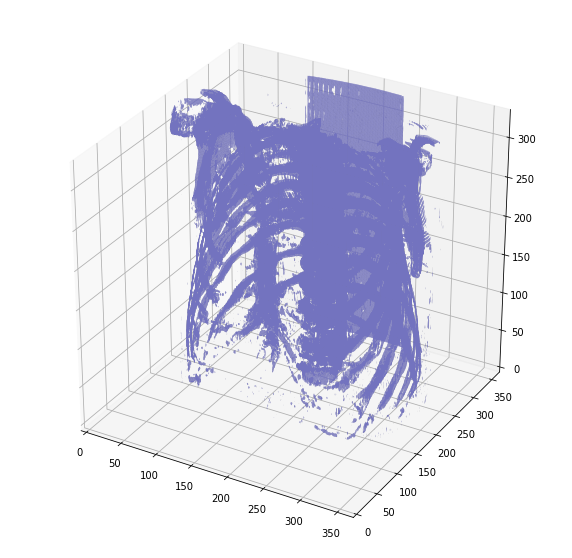

In [22]:
def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    verts, faces = measure.marching_cubes_classic(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()
    
plot_3d(pix_resampled, 400)

In [23]:
# # plot 3 orthogonal slices
# a1 = plt.subplot(2, 2, 1)
# plt.imshow(img3d[:, :, img_shape[2]//2])
# a1.set_aspect(ax_aspect)

# a2 = plt.subplot(2, 2, 2)
# plt.imshow(img3d[:, img_shape[1]//2, :])
# a2.set_aspect(sag_aspect)

# a3 = plt.subplot(2, 2, 3)
# plt.imshow(img3d[img_shape[0]//2, :, :].T)
# a3.set_aspect(cor_aspect)

# plt.show()

In [24]:
# plt.figure(dpi=300)
# plt.axes().set_aspect('equal', 'datalim')
# plt.set_cmap(plt.gray())
# plt.pcolormesh(np.flipud(img3d[:, :, 80]))

In [25]:
def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None
    
def segment_lung_mask(image, fill_lung_structures=True):
    
    # not actually binary, but 1 and 2. 
    # 0 is treated as background, which we do not want
    binary_image = np.array(image > -320, dtype=np.int8)+1
    labels = measure.label(binary_image)
    
    # Pick the pixel in the very corner to determine which label is air.
    #   Improvement: Pick multiple background labels from around the patient
    #   More resistant to "trays" on which the patient lays cutting the air 
    #   around the person in half
    background_label = labels[0,0,0]
    
    #Fill the air around the person
    binary_image[background_label == labels] = 2
    
    # Method of filling the lung structures (that is superior to something like 
    # morphological closing)
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
            
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1

    
    binary_image -= 1 #Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1
    
    # Remove other air pockets insided body
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0
 
    return binary_image

In [26]:
%%time

segmented_lungs = segment_lung_mask(pix_resampled, False)
segmented_lungs_fill = segment_lung_mask(pix_resampled, True)

Wall time: 18.3 s


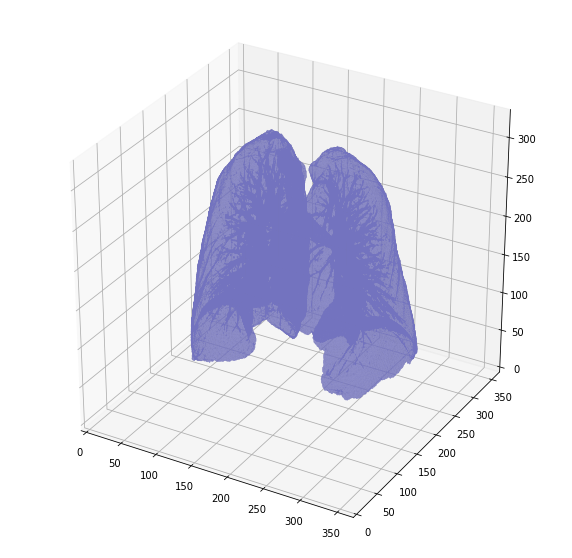

In [27]:
plot_3d(segmented_lungs, 0)

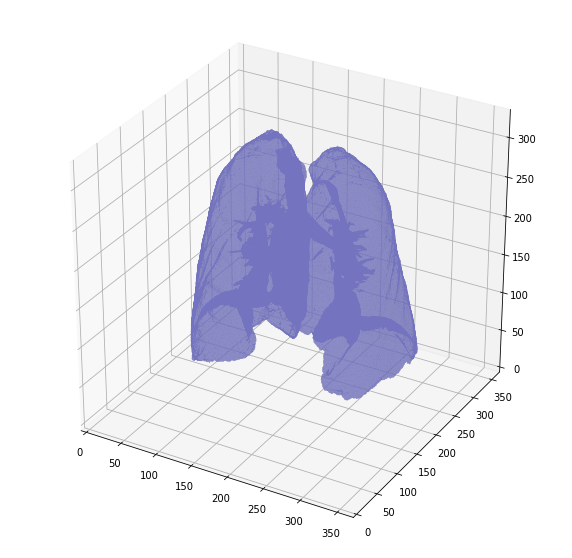

In [28]:
plot_3d(segmented_lungs_fill, 0)

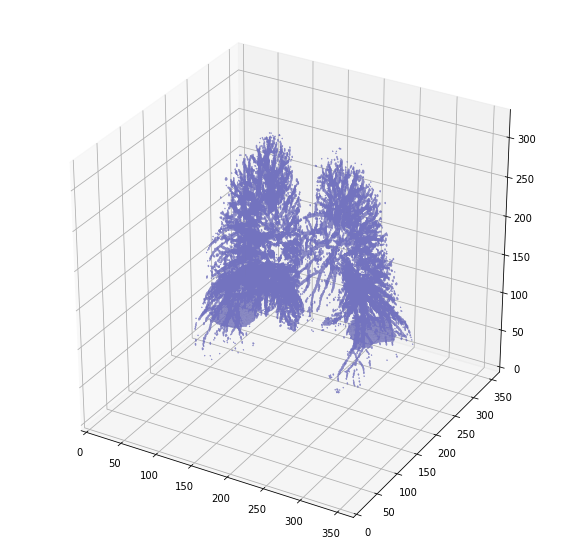

In [29]:
plot_3d(segmented_lungs_fill - segmented_lungs, 0)

In [ ]:
MIN_BOUND = -1000.0
MAX_BOUND = 400.0
PIXEL_MEAN = 0.25

def normalize(image):
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image>1] = 1.
    image[image<0] = 0.
    return image

def zero_center(image):
    image = image - PIXEL_MEAN
    return image